# Pneumonia detection with ANN

In [13]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score


from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)


2.7.0


In [14]:
BATCH_SIZE = 8
EPOCHS = 20
IMAGE_SIZE = (512, 512)
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)

In [15]:
# Detect TPU, return appropriate distribution strategy
 #try:
    #tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
  #print('Running on TPU ', tpu.master())
 #except ValueError:
    #tpu = None

#if tpu:
    #tf.config.experimental_connect_to_cluster(tpu)
     #tf.tpu.experimental.initialize_tpu_system(tpu)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
 #else:
     #strategy = tf.distribute.get_strategy() 

#print("REPLICAS: ", strategy.num_replicas_in_sync)

In [16]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [17]:
for dirname, _, filenames in os.walk('C:/Users/Ali Ehab/archive/chest_xray/chest_xray'):
    print(dirname)

C:/Users/Ali Ehab/archive/chest_xray/chest_xray
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\test
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\test\NORMAL
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\test\PNEUMONIA
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\train
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\train\NORMAL
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\train\PNEUMONIA
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\val
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\val\NORMAL
C:/Users/Ali Ehab/archive/chest_xray/chest_xray\val\PNEUMONIA


# All filenames

In [18]:
filenames = tf.io.gfile.glob('C:/Users/Ali Ehab/archive/chest_xray/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob('C:/Users/Ali Ehab/archive/chest_xray/chest_xray/val/*/*'))
filenames.extend(tf.io.gfile.glob('C:/Users/Ali Ehab/archive/chest_xray/chest_xray/test/*/*'))
filenames[:3]

['C:\\Users\\Ali Ehab\\archive\\chest_xray\\chest_xray\\train\\NORMAL\\.DS_Store',
 'C:\\Users\\Ali Ehab\\archive\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0115-0001.jpeg',
 'C:\\Users\\Ali Ehab\\archive\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg']

# To DataFrame

In [19]:
data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('\\')[-2]
    path = filenames[el]
    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data[:10]

PNEUMONIA    4275
NORMAL       1585
Name: class, dtype: int64


,filename,class
0,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
1,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
2,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
3,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
4,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
5,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
6,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
7,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
8,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
9,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL


# Shuffle Data

In [20]:
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data[:10]

,filename,class
0,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
1,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
2,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
3,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
4,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,PNEUMONIA
5,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,PNEUMONIA
6,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
7,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,NORMAL
8,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,PNEUMONIA
9,C:\Users\Ali Ehab\archive\chest_xray\chest_xra...,PNEUMONIA


# Drop out trash

In [21]:
indexes=[]

def func(x):
    if x[-5:] != '.jpeg':
        idx = data[data['filename'] == x].index
        indexes.append(idx[0])
        print(idx[0], x)
    return x

data['filename'].map(func)

print(data.shape)
data.drop(index=indexes, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

2641 C:\Users\Ali Ehab\archive\chest_xray\chest_xray\train\NORMAL\.DS_Store
3497 C:\Users\Ali Ehab\archive\chest_xray\chest_xray\val\NORMAL\.DS_Store
4852 C:\Users\Ali Ehab\archive\chest_xray\chest_xray\val\PNEUMONIA\.DS_Store
4933 C:\Users\Ali Ehab\archive\chest_xray\chest_xray\train\PNEUMONIA\.DS_Store
(5860, 2)
(5856, 2)


# SPLIT train_data, test_data

In [22]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['class'])
print(test_data.shape)
test_data = test_data[ : test_data.shape[0] // BATCH_SIZE * BATCH_SIZE]
print(test_data.shape)
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

(586, 2)
(584, 2)
PNEUMONIA    3845
NORMAL       1425
Name: class, dtype: int64
PNEUMONIA    426
NORMAL       158
Name: class, dtype: int64


# SPLIT train_data, val_data

In [23]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

PNEUMONIA    3076
NORMAL       1140
Name: class, dtype: int64
PNEUMONIA    769
NORMAL       285
Name: class, dtype: int64


# Define ImageDataGenerator and Augmentation(for train only!)

In [24]:
# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, # 0.05
                             brightness_range=[0.9, 1.0],
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=10,  # 5
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        target_size=(IMAGE_SIZE),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4216 validated image filenames belonging to 2 classes.
Found 1054 validated image filenames belonging to 2 classes.
Found 584 validated image filenames belonging to 2 classes.


In [25]:
train_ds = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

val_ds = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

test_ds = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, *IMAGE_SIZE, 1], [None, ]))

# Augmentated data

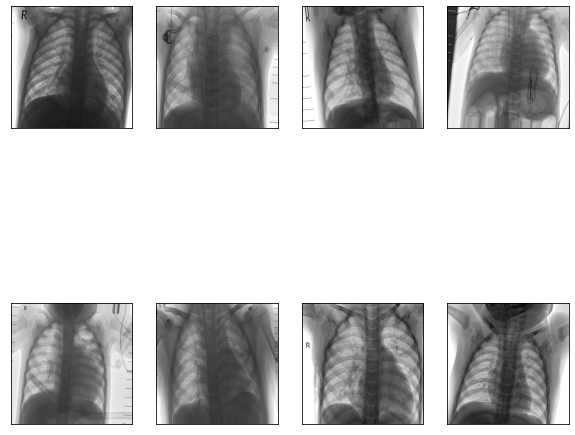

In [26]:
plt.figure(figsize=(10,10))
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE//4 ,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_gen[0][0][i], cmap=plt.cm.binary)
plt.show()

# Validation Data

In [62]:
# Improving the ANN
def create_model():
    
    with tf.device('/gpu:0'):
#     with strategy.scope():
    
        # Model input
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 1), name='input')    

        # First block
        x = layers.Conv2D(filters=64, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(input_layer)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_1')(x)

        # Second block
        x = layers.Conv2D(filters=96, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_2')(x)

        # Third block
        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_3')(x)

        # Fourth block
        x = layers.Conv2D(filters=160, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_4')(x)

        # Fifth block
        x = layers.Conv2D(filters=192, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_5')(x)

        # Sixth block
        x = layers.Conv2D(filters=224, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_6')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_6')(x)

        # Seventh block
        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_7')(x)
        x = layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')(x)
        x = layers.Dropout(0.1, name='dropout_7')(x)

        # Pooling and output
        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)    
        output = layers.Dense(units=1, 
                              activation='sigmoid', 
                              name='output')(x)

        # Model creation and compilation

        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
dense_14 (Dense)             (None, 512, 512, 6)       390       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 96)      5280      
_________________________________________________________________
dense_15 (Dense)             (None, 512, 512, 6)       582       
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 512, 6)       0   

In [63]:
# plot_model(model, show_shapes=True)

In [64]:
def feed_data(dataset):
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  

Epoch 1/2
527/527 [==============================] - 5218s 10s/step - loss: 0.5906 - accuracy: 0.7291 - val_loss: 0.5856 - val_accuracy: 0.7281
Epoch 2/2
527/527 [==============================] - 4969s 9s/step - loss: 0.5859 - accuracy: 0.7296 - val_loss: 0.5870 - val_accuracy: 0.7281
Minimum Validation Loss: 0.5856

Required time:  2:49:47.528105



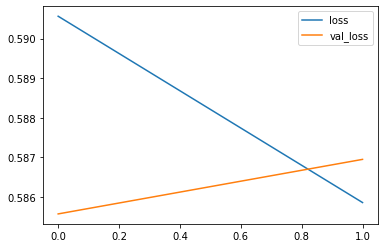

In [39]:
init_time = datetime.datetime.now()


STEPS_PER_EPOCH = train_gen.samples // BATCH_SIZE
VALIDATION_STEPS = val_gen.samples // BATCH_SIZE

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)


history = model.fit(
    feed_data(train_ds),
    validation_data=feed_data(val_ds),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    callbacks=[learning_rate_reduction],
    verbose=1,
    )

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));



requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

In [65]:
test_steps = test_gen.samples // BATCH_SIZE

test_loss, test_acc = model.evaluate(test_ds, steps=test_steps)
print('\naccuracy:', test_acc, 'loss: ',test_loss)

73/73 [==============================] - 176s 2s/step - loss: 0.6931 - accuracy: 0.2705

accuracy: 0.2705479562282562 loss:  0.6931468844413757


In [66]:
predict = model.predict(test_ds, steps=test_steps)
y_hat = np.where(predict > 0.5, 1, 0).ravel()
y_hat[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
test_labels_df = pd.DataFrame()
test_labels_df[['class']] = test_data[['class']]
test_labels_df['class'] = test_labels_df['class'].map({'NORMAL':0, 'PNEUMONIA':1})

y_test = np.array(test_labels_df['class'])
y_test[:20]

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0],
      dtype=int64)

# Classification report

              precision    recall  f1-score   support

           0       0.27      1.00      0.43       158
           1       0.00      0.00      0.00       426

    accuracy                           0.27       584
   macro avg       0.14      0.50      0.21       584
weighted avg       0.07      0.27      0.12       584
 



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

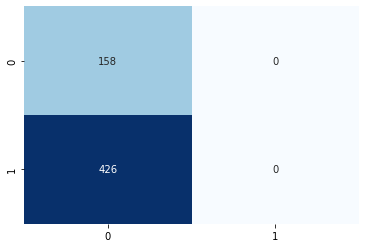

In [68]:
print(classification_report(y_test, y_hat), '\n')
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)